<a href="https://colab.research.google.com/github/JackRich1/NV-cavity-QED/blob/main/MCG_Dataset_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file contains code that generates a dataset of Magnetocardiogrophy (MCG) samples. The dataset uses an open source dataset of the B field response to heartbeats and is spliced such that some samples contain heartbeats and others do not. The samples are also run through the function that computes what the actual refelcted MW signal that the magnetometer would measure would be.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 9.1 MB/s eta 0:00:00


In [ ]:
data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data'
import wfdb

recording_name_raw = 'subject1_raw_trial01'
record_raw = wfdb.rdrecord(f'{data_folder}/{recording_name_raw}')

signal_data_raw = record_raw.p_signal  # The physiological signal data (in a NumPy array)
fs_raw = record_raw.fs  # Sampling frequency
channels_raw = record_raw.sig_name  # Names of the channels (if multiple)

print(f"Sampling frequency: {fs_raw} Hz")
print(f"Signal shape: {signal_data_raw.shape}")
print(f"Channels: {channels_raw}")


Sampling frequency: 200 Hz
Signal shape: (3574784, 8)
Channels: ['Sensor 0  -Y', 'Sensor 0  Z', 'Sensor 1  -Y', 'Sensor 1  Z', 'Sensor 2  -Y', 'Sensor 2  X', 'Sensor 3  -Y', 'Sensor 3  X']


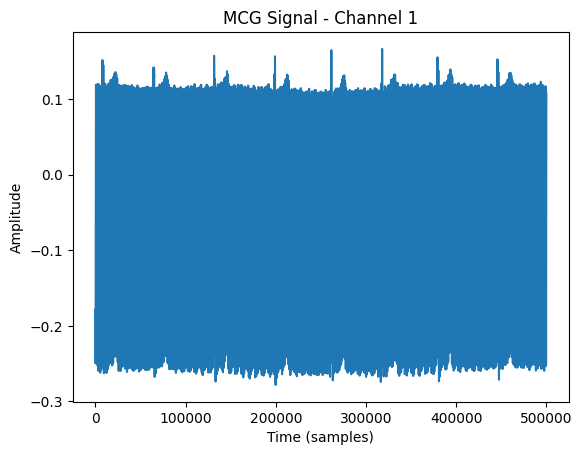

In [ ]:
import matplotlib.pyplot as plt

# Plot the first channel (assuming there are multiple channels)
plt.plot(signal_data_raw[1000000:1500000, 1])
plt.title("MCG Signal - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [ ]:
#same but for pre-processed data

recording_name_processed = 'subject1_preprocessed_trial01'
record_processed = wfdb.rdrecord(f'{data_folder}/{recording_name_processed}')

signal_data_processed = record_processed.p_signal  # The physiological signal data (in a NumPy array)
fs_processed = record_processed.fs  # Sampling frequency
channels_processed = record_processed.sig_name  # Names of the channels (if multiple)

print(f"Sampling frequency: {fs_processed} Hz")
print(f"Signal shape: {signal_data_processed.shape}")
print(f"Channels: {channels_processed}")


Sampling frequency: 200 Hz
Signal shape: (13964, 8)
Channels: ['Sensor 0  -Y', 'Sensor 0  Z', 'Sensor 1  -Y', 'Sensor 1  Z', 'Sensor 2  -Y', 'Sensor 2  X', 'Sensor 3  -Y', 'Sensor 3  X']


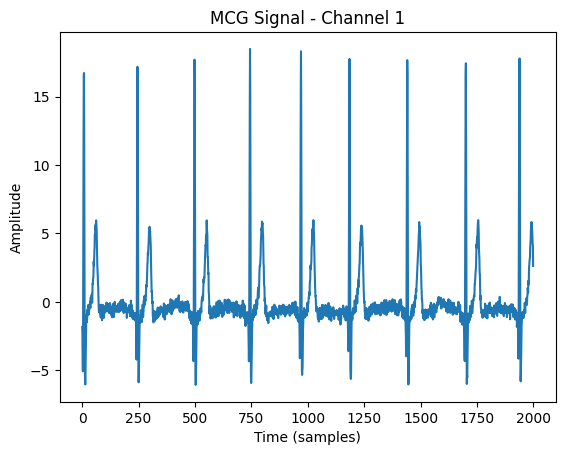

In [ ]:
import matplotlib.pyplot as plt

# Plot the first channel (assuming there are multiple channels)
plt.plot(signal_data_processed[2000:4000, 1])
plt.title("MCG Signal - Channel 1")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()

Sampling frequency: 200 Hz
Signal shape: (13964, 8)
Channels: ['Sensor 0  -Y', 'Sensor 0  Z', 'Sensor 1  -Y', 'Sensor 1  Z', 'Sensor 2  -Y', 'Sensor 2  X', 'Sensor 3  -Y', 'Sensor 3  X']


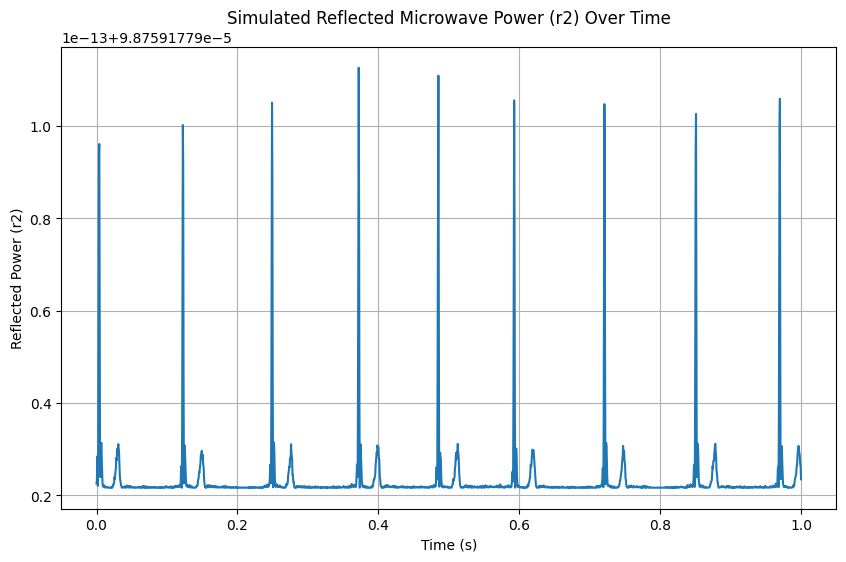

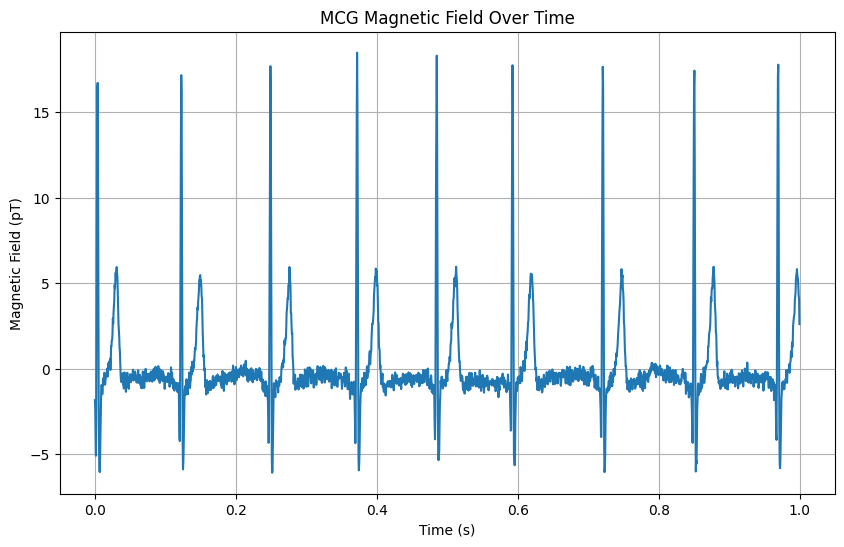

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import wfdb

# Constants
g_e = 2.00231930436256  # Electron g-factor
mu_B = 9.274009994e-24  # Bohr magneton (J/T)
h = 6.626e-34  # Planck constant (J·s)
kc1 = 130e3    # Cavity loop coupling (Hz)
gammao = 2.23e3  # Optical polarization rate (Hz)
gamma_th = 90.0  # Thermal relaxation rate (Hz)
rho = 4.0       # NV density (unitless)
Vd = 3e-3 * 3e-3 * 0.9e-3  # Diamond volume (m^3)
Gamma = (330e3 / 4) * rho  # Inhomogeneous linewidth (Hz)
k = 260e3       # Total cavity decay rate (Hz)
# Compute excitation rate I based on effecgive optical polarization rate gammao
I = 1.225 * gammao - 4.809 * gamma_th + 3.085 * np.sqrt(
    0.1577 * gammao ** 2 - 0.5229 * gammao * gamma_th + gamma_th ** 2)

Polarization = (0.29 * I) / (3 * gamma_th + 0.38 * I)

N = (rho * 3.51 / 12.01 * 6.022e23) * Vd  # Number of NV centers

base_frequency = 2.87e9  # Base resonance frequency (Hz)
gamma_true = 55e3        # True gamma value (Hz)
gs_true = 0.019          # True gs value

# --- Load MCG Data ---
data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data'
recording_name_processed = 'subject1_preprocessed_trial01'

# Read the signal and metadata
record_processed = wfdb.rdrecord(f'{data_folder}/{recording_name_processed}')

# Extract data
signal_data_processed = record_processed.p_signal  # The physiological signal data (in a NumPy array)
fs_processed = record_processed.fs  # Sampling frequency
channels_processed = record_processed.sig_name  # Names of the channels (if multiple)

# Display information
print(f"Sampling frequency: {fs_processed} Hz")
print(f"Signal shape: {signal_data_processed.shape}")
print(f"Channels: {channels_processed}")

# For the purpose of this example, we'll assume a higher sampling frequency
fs_eff = 2000  # Effective sampling frequency in Hz

# --- Extract a Segment of the MCG Data ---
num_samples = 2000  # Number of samples to process
channel_index = 1    # Index of the channel to use (e.g., 0 for 'Sensor 0 -Y')
B_field_pT = signal_data_processed[2000:2000+num_samples, channel_index]
B_field_T = B_field_pT * 1e-12  # Convert pT to T

# Compute delta_f (frequency shift due to B-field) and spin resonance frequencies
delta_f = (g_e * mu_B) / h * B_field_T  # Units: Hz
spin_freq = base_frequency + delta_f  # Units: Hz
frequency = base_frequency  # Drive frequency, Units: Hz

# --- Simulate r2 over Time ---
def simulate_r2_numpy_vectorized(frequency, spin_freq, gamma, gs):
    h_np = 6.626e-34
    energy_d = h_np * frequency   # h * omega
    Delta = spin_freq - frequency  # Detuning of microwave drive from resonance
    g = np.sqrt(N * Polarization) * gs * 0.16  # Collective coupling strength
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = np.sqrt(1 + 8 * (gamma / gammao) * (gs ** 2) * alpha2 / (gamma ** 2))
    Gamma_1_0 = Gamma + chi_0 * gamma
    geff_0 = g / chi_0
    denom = (Delta - (g ** 2) * Delta / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2 + \
            (k / 2 + (geff_0 ** 2) * (Gamma_1_0 / 2) / ((Gamma_1_0 / 2) ** 2 + Delta ** 2)) ** 2
    term1 = kc1 * beta2
    alpha2_1 = term1 / denom
    r2 = (-1 + np.sqrt(kc1 * alpha2_1 / beta2 + 1e-12)) ** 2
    return r2

# Simulate r2 values
r2_values = simulate_r2_numpy_vectorized(frequency, spin_freq, gamma_true, gs_true)

# --- Plot r2 over Time ---
# Create a time vector (assuming effective sampling frequency)
time_vector = np.arange(num_samples) / fs_eff  # Time in seconds

# Plot r2 over time
plt.figure(figsize=(10, 6))
plt.plot(time_vector, r2_values)
plt.xlabel('Time (s)')
plt.ylabel('Reflected Power (r2)')
plt.title('Simulated Reflected Microwave Power (r2) Over Time')
plt.grid(True)
plt.show()

# --- Optionally, Plot B-field over Time ---
plt.figure(figsize=(10, 6))
plt.plot(time_vector, B_field_pT)
plt.xlabel('Time (s)')
plt.ylabel('Magnetic Field (pT)')
plt.title('MCG Magnetic Field Over Time')
plt.grid(True)
plt.show()


In [ ]:
processed_len = signal_data_processed.shape[0]
raw_len = signal_data_raw.shape[0]
print(f"Signal shape: {signal_data_processed.shape}")
print(f"Signal shape: {signal_data_raw.shape}")
scale_raw = raw_len/processed_len
print(raw_len/processed_len)

Signal shape: (13964, 8)
Signal shape: (3574784, 8)
256.0


In [ ]:
from scipy.signal import butter, sosfiltfilt, iirnotch
import scipy.signal as signal

In [ ]:
from scipy.signal import butter, sosfiltfilt, iirnotch



num_samples = 2000
offset = 2000
raw_segment = signal_data_raw[:,1]
processed_segment = signal_data_processed[:,1]

sensitivity = 200e-15  # 200 fT in T
# Since the preprocessed data is in pT, we can scale the raw data accordingly
# Find scaling factor to match the amplitudes
scaling_factor = np.std(processed_segment) / np.std(raw_segment)

# Apply scaling factor
raw_segment_scaled = raw_segment * scaling_factor
raw_segment_scaled = raw_segment_scaled - np.mean(raw_segment_scaled)


# Now, the raw data is approximately in pT
filtered_data = raw_segment_scaled  # Use scaled raw data for filtering


def butter_bandpass(lowcut, highcut, fs, order=4):  # Changed order to 4
    nyq = 0.5 * fs  # Nyquist Frequency
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='bandpass', output='sos')
    return sos

def butter_notch(center_freq, fs, Q=30):
    nyq = 0.5 * fs
    freq = center_freq / nyq
    b, a = iirnotch(freq, Q)
    sos = signal.tf2sos(b, a)
    return sos




NaN in filtered_data after bandpass: False
NaN in filtered_data after notch filter: False


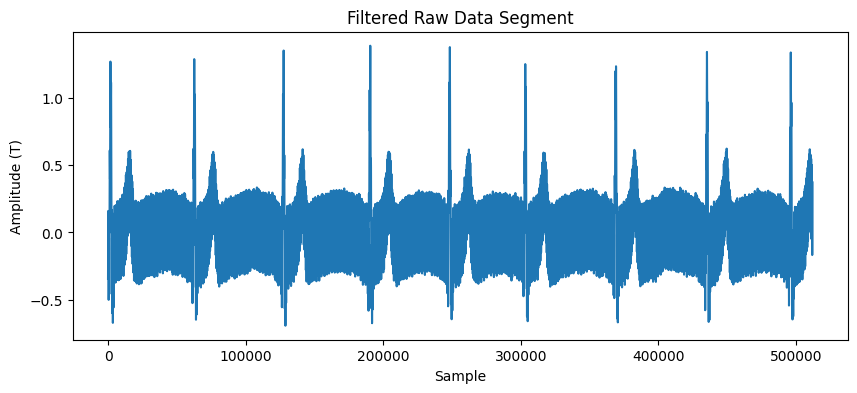

In [ ]:
fs_raw = 256*200  # Should be 200 Hz

# Filter parameters
lowcut = 1.0    # Hz
highcut = 100.0 # Hz
order = 5

#  bandpass filter
sos_bandpass = butter_bandpass(lowcut, highcut, fs_raw, order=4)
filtered_data = sosfiltfilt(sos_bandpass, raw_segment_scaled)

# Check for NaNs after bandpass filtering
print('NaN in filtered_data after bandpass:', np.isnan(filtered_data).any())

# notch filter at 50 Hz
center_freq = 50.0  # Hz
Q = 30.0            # Quality factor
sos_notch = butter_notch(center_freq, fs_raw, Q=Q)
filtered_data = sosfiltfilt(sos_notch, filtered_data)

filtered_data = filtered_data[int(offset*scale_raw):int(scale_raw*(offset+num_samples))]


# Check for NaNs after notch filtering
print('NaN in filtered_data after notch filter:', np.isnan(filtered_data).any())

plt.figure(figsize=(10, 4))
plt.plot(filtered_data)
plt.title('Filtered Raw Data Segment')
plt.xlabel('Sample')
plt.ylabel('Amplitude (T)')
plt.show()


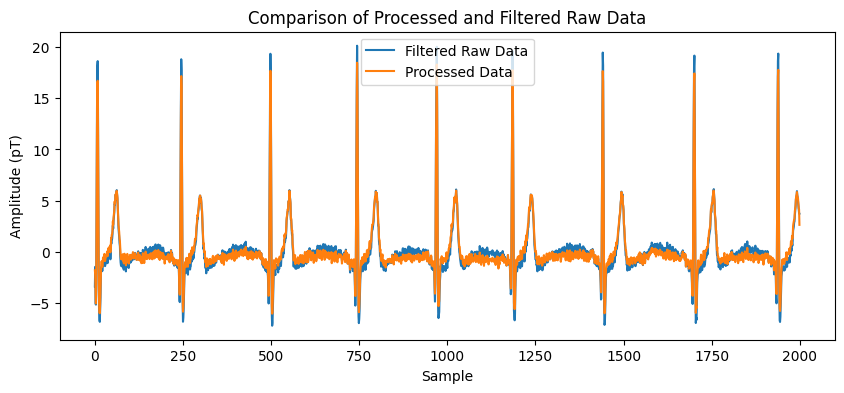

In [ ]:
filtered_data_pT = filtered_data * 1e12  # Convert T to pT

from scipy.signal import decimate

decimation_factor = int(fs_raw / fs_processed)  # 256

# Downsample the filtered data
filtered_data_downsampled = decimate(filtered_data, decimation_factor, ftype='iir')

# Now, filtered_data_downsampled should have the same length as processed_segment
# Calculate scaling factor using the downsampled filtered data
scaling_factor = np.std(processed_segment) / np.std(filtered_data_downsampled)

# Apply scaling factor
filtered_data_downsampled_scaled = filtered_data_downsampled * scaling_factor



plt.figure(figsize=(10, 4))
plt.plot(filtered_data_downsampled_scaled, label='Filtered Raw Data')
plt.plot(processed_segment[offset:offset+num_samples], label='Processed Data')
plt.title('Comparison of Processed and Filtered Raw Data')
plt.xlabel('Sample')
plt.ylabel('Amplitude (pT)')
plt.legend()
plt.show()


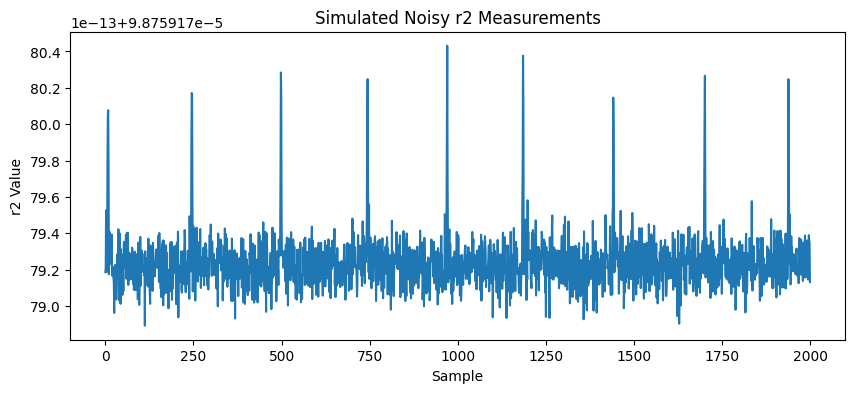

In [ ]:
B_field_pT = filtered_data_downsampled_scaled  # Use the filtered data
B_field_T = B_field_pT * 1e-12  # Convert pT to T

C = (g_e * mu_B) / h  # Units: Hz/T
delta_f = C * B_field_T  # Units: Hz
spin_freq = base_frequency + delta_f  # Units: Hz

frequency = base_frequency  # Units: Hz

r2_values = simulate_r2_numpy_vectorized(frequency, spin_freq, gamma_true, gs_true)

noise_level = 1e-14
r2_noisy = r2_values + np.random.normal(0, noise_level, size=r2_values.shape)

plt.figure(figsize=(10, 4))
plt.plot(r2_noisy)
plt.title('Simulated Noisy r2 Measurements')
plt.xlabel('Sample')
plt.ylabel('r2 Value')
plt.show()


/usr/local/lib/python3.10/dist-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


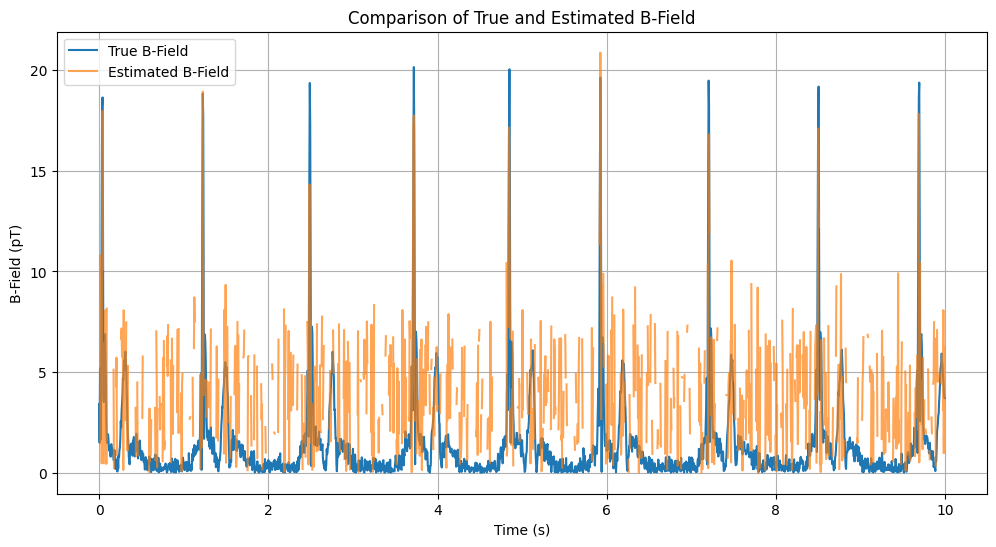

In [ ]:
from scipy.interpolate import interp1d

B_values_map = np.linspace(-50e-12, 50e-12,1000)
delta_f = (g_e * mu_B) / h * B_values_map  # Units: Hz
spin_freq_values_map = base_frequency + delta_f  # Units: Hz
frequency = base_frequency

r2_values_map = simulate_r2_numpy_vectorized(frequency, spin_freq_values_map, gamma_true, gs_true)

# Interpolate to estimate B-field values from r2_noisy
sorted_indices = np.argsort(r2_values_map)
r2_values_sorted = r2_values_map[sorted_indices]
B_values_sorted = B_values_map[sorted_indices]
interpolation_function = interp1d(r2_values_sorted, B_values_sorted, bounds_error=False, fill_value='extrapolate')

# Estimate B-field values from r2_noisy
B_field_estimated = interpolation_function(r2_noisy) *1e12

time_vector = np.arange(num_samples) / fs_processed  # Use fs_processed (200 Hz)

# Plot the true and estimated B-field
plt.figure(figsize=(12, 6))
plt.plot(time_vector, np.abs(B_field_pT[:num_samples]), label='True B-Field')
plt.plot(time_vector, np.abs(B_field_estimated[:num_samples]), label='Estimated B-Field', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('B-Field (pT)')
plt.title('Comparison of True and Estimated B-Field')
plt.legend()
plt.grid(True)
# plt.plot(B_values_sorted,r2_values_sorted)
plt.show()



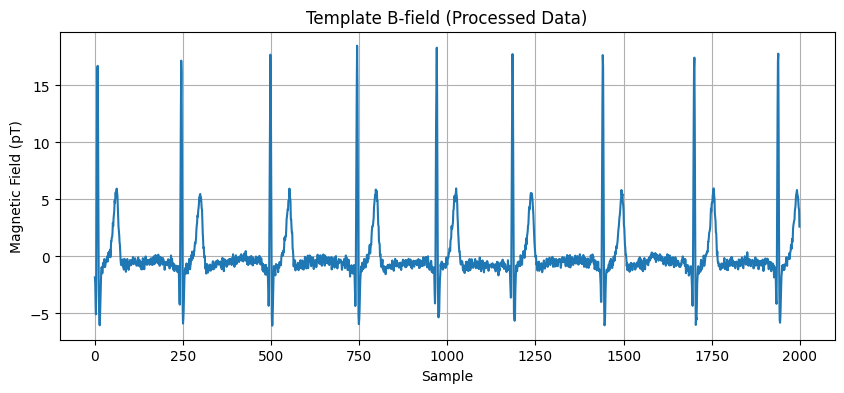

In [ ]:
# --- Step 1: Create the Template ---

# Parameters
channel_index = 1  # Adjust if needed
fs_processed = record_processed.fs  # Sampling frequency of processed data

# Template time interval (in seconds)
template_start_time = 10.0  # Start time for the template (e.g., 10 seconds)
template_duration = 10.0     # Duration of the template (e.g., 5 seconds)

# Calculate sample indices for the template
template_start_idx = int(template_start_time * fs_processed)
template_end_idx = int((template_start_time + template_duration) * fs_processed)

# Extract the B-field template from the processed data
B_field_pT_template = signal_data_processed[template_start_idx:template_end_idx, channel_index]

# Plot the template B-field
plt.figure(figsize=(10, 4))
plt.plot(B_field_pT_template)
plt.title('Template B-field (Processed Data)')
plt.xlabel('Sample')
plt.ylabel('Magnetic Field (pT)')
plt.grid(True)
plt.show()


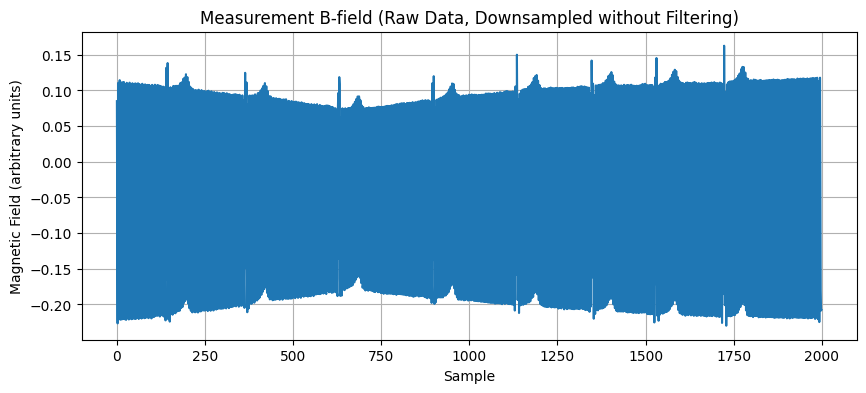

In [ ]:
# --- Step 2: Prepare the Measurement Data ---

# Raw data sampling frequency
fs_raw = fs_processed * 256  # Assuming raw data is sampled at 51,200 Hz

# Measurement time interval (in seconds)
measurement_start_time = 30.0  # Start time for the measurement data (e.g., 30 seconds)
measurement_duration = 10.0    # Duration of the measurement data (e.g., 10 seconds)

# Ensure the measurement data does not overlap with the template
assert measurement_start_time >= template_start_time + template_duration or \
       measurement_start_time + measurement_duration <= template_start_time, \
       "Measurement data overlaps with template data!"

# Calculate sample indices for the measurement data in the raw data
measurement_start_idx = int(measurement_start_time * fs_raw)
measurement_end_idx = int((measurement_start_time + measurement_duration) * fs_raw)

# Extract the B-field measurement from the raw data
B_field_raw = signal_data_raw[:, channel_index]
B_field_raw_segment = B_field_raw[measurement_start_idx:measurement_end_idx]

# Downsample the raw data to match the processed data sampling rate
from scipy.signal import decimate

decimation_factor = int(fs_raw / fs_processed)  # Should be 256
B_field_raw_downsampled = decimate(B_field_raw_segment, decimation_factor, zero_phase=True)

# Ensure the measurement data length is sufficient
assert len(B_field_raw_downsampled) >= len(B_field_pT_template), \
    "Measurement data segment is shorter than the template!"

# Truncate or select a portion of the measurement data to match the length of the template
B_field_pT_measurement = B_field_raw_downsampled[:len(B_field_pT_template)]

# Plot the measurement B-field
plt.figure(figsize=(10, 4))
plt.plot(B_field_pT_measurement)
plt.title('Measurement B-field (Raw Data, Downsampled without Filtering)')
plt.xlabel('Sample')
plt.ylabel('Magnetic Field (arbitrary units)')
plt.grid(True)
plt.show()


In [ ]:
# --- Normalize and Align the Data ---

# Since the amplitudes may differ, we can normalize both signals
B_field_template_normalized = (B_field_pT_template - np.mean(B_field_pT_template)) / np.std(B_field_pT_template)
B_field_measurement_normalized = (B_field_raw_downsampled - np.mean(B_field_raw_downsampled)) / np.std(B_field_raw_downsampled)


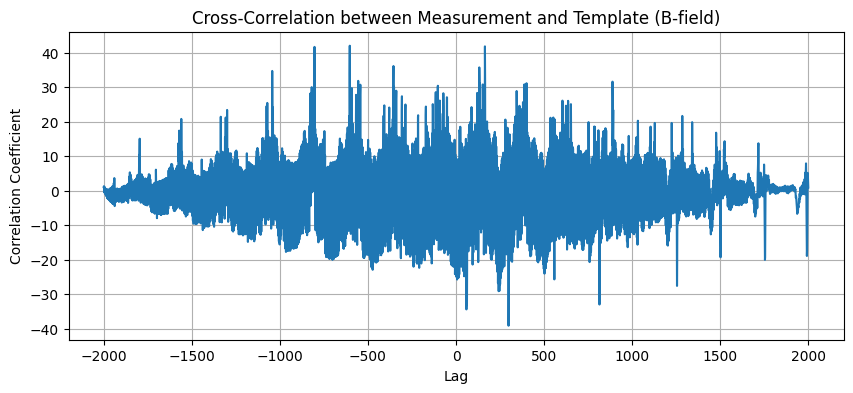

In [ ]:
# --- Step 3: Compute the Cross-Correlation ---

from scipy.signal import correlate

# Compute cross-correlation
correlation = correlate(B_field_measurement_normalized, B_field_template_normalized, mode='full')
lags = np.arange(-len(B_field_measurement_normalized) + 1, len(B_field_template_normalized))

# Plot the cross-correlation
plt.figure(figsize=(10, 4))
plt.plot(lags, correlation)
plt.title('Cross-Correlation between Measurement and Template (B-field)')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()


Maximum correlation at lag -603 with value 42.016983864582635


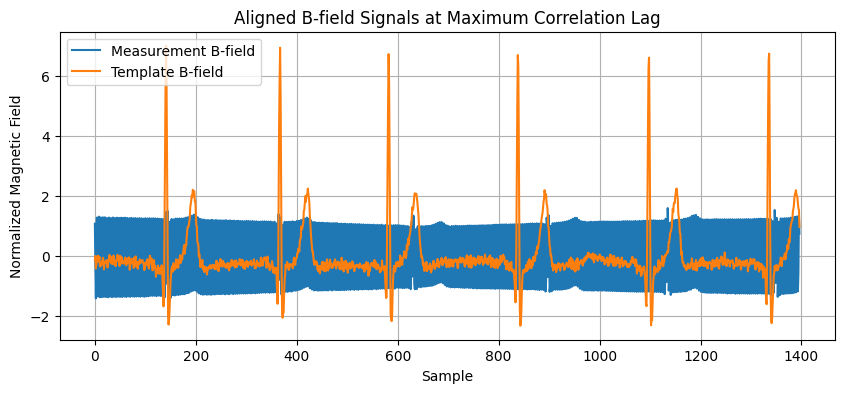

In [ ]:
# --- Step 4: Analyze and Visualize the Results ---

# Find the lag with the maximum correlation
max_corr_index = np.argmax(correlation)
max_corr_value = correlation[max_corr_index]
max_corr_lag = lags[max_corr_index]

print(f"Maximum correlation at lag {max_corr_lag} with value {max_corr_value}")

# Align the signals based on the lag
if max_corr_lag < 0:
    # Template starts after the measurement
    aligned_template = B_field_template_normalized[-max_corr_lag:]
    aligned_measurement = B_field_measurement_normalized[:len(aligned_template)]
elif max_corr_lag > 0:
    # Template starts before the measurement
    aligned_measurement = B_field_measurement_normalized[max_corr_lag:]
    aligned_template = B_field_template_normalized[:len(aligned_measurement)]
else:
    # No shift needed
    aligned_template = B_field_template_normalized
    aligned_measurement = B_field_measurement_normalized

# Ensure the signals are the same length
min_length = min(len(aligned_template), len(aligned_measurement))
aligned_template = aligned_template[:min_length]
aligned_measurement = aligned_measurement[:min_length]

# Plot the aligned signals
plt.figure(figsize=(10, 4))
plt.plot(aligned_measurement, label='Measurement B-field')
plt.plot(aligned_template, label='Template B-field')
plt.title('Aligned B-field Signals at Maximum Correlation Lag')
plt.xlabel('Sample')
plt.ylabel('Normalized Magnetic Field')
plt.legend()
plt.grid(True)
plt.show()


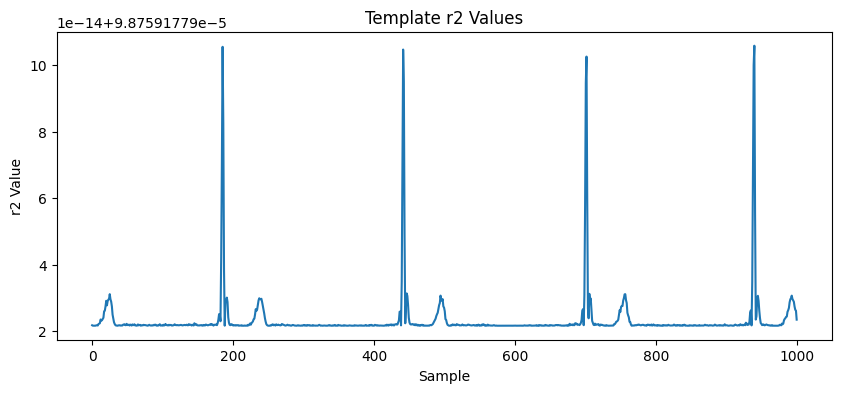

In [ ]:
# --- Step 1: Create the Template ---

# Define the number of samples for the template
template_num_samples = 1000  # You can adjust this as needed
template_offset = 3000       # Starting index for the template

# Extract the B-field segment for the template
B_field_pT_template = signal_data_processed[template_offset:template_offset + template_num_samples, channel_index]
B_field_T_template = B_field_pT_template * 1e-12  # Convert pT to T

# Compute delta_f and spin frequencies for the template
delta_f_template = (g_e * mu_B) / h * B_field_T_template  # Units: Hz
spin_freq_template = base_frequency + delta_f_template  # Units: Hz

# Simulate r2 values for the template
r2_template = simulate_r2_numpy_vectorized(frequency, spin_freq_template, gamma_true, gs_true)

# Plot the template r2 values
plt.figure(figsize=(10, 4))
plt.plot(r2_template)
plt.title('Template r2 Values')
plt.xlabel('Sample')
plt.ylabel('r2 Value')
plt.show()


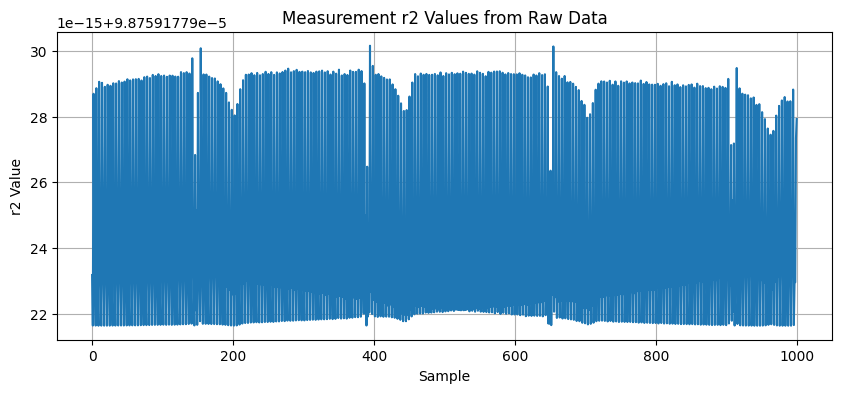

In [ ]:
# --- Step 2: Prepare the Measurement Data Using Raw Data with Correct Scaling ---

# Sampling rates
fs_processed = record_processed.fs  # Should be 200 Hz
fs_raw = record_raw.fs             # Should be 51,200 Hz

# Scale factor between raw and processed data
# scale_raw = int(fs_raw / fs_processed)  # Should be 256
# print(scale_raw)
scale_raw = 256

# Define the number of samples and offsets in terms of processed data
measurement_num_samples_processed = 1000  # Number of samples in processed data
measurement_offset_processed = 5000       # Offset in processed data samples

# Convert to raw data indices
measurement_num_samples_raw = measurement_num_samples_processed * scale_raw
measurement_offset_raw = measurement_offset_processed * scale_raw

# Ensure that the measurement data does not overlap with the template data
template_end_processed = template_offset + template_num_samples
if measurement_offset_processed >= template_end_processed or measurement_offset_processed + measurement_num_samples_processed <= template_offset:
    # No overlap in processed data time
    pass
else:
    raise ValueError("Measurement data overlaps with template data in processed data time scale!")

# Extract raw data segment using raw data indices
channel_index = 1  # Ensure this matches the channel used in the template
B_field_raw = signal_data_raw[:, channel_index]

# Extract the segment from raw data
B_field_raw_segment = B_field_raw[measurement_offset_raw : measurement_offset_raw + measurement_num_samples_raw]

# Downsample the raw data to match the processed data sampling rate
from scipy.signal import decimate

decimation_factor = scale_raw  # 256
B_field_raw_downsampled = decimate(B_field_raw_segment, decimation_factor, zero_phase=True)

# Ensure the downsampled data has the same length as the processed data segment
assert len(B_field_raw_downsampled) == measurement_num_samples_processed, "Downsampled raw data length does not match!"

# Since the raw data might have different amplitude scaling, apply scaling if necessary
# For this example, we'll assume the raw data is in arbitrary units and scale it to match the processed data
scaling_factor = np.std(signal_data_processed[:, channel_index]) / np.std(B_field_raw_downsampled)
B_field_pT_measurement = B_field_raw_downsampled * scaling_factor
B_field_T_measurement = B_field_pT_measurement * 1e-12  # Convert pT to T

# Compute delta_f and spin frequencies for the measurement data
delta_f_measurement = (g_e * mu_B) / h * B_field_T_measurement  # Units: Hz
spin_freq_measurement = base_frequency + delta_f_measurement    # Units: Hz

# Simulate r2 values for the measurement data
r2_measurement = simulate_r2_numpy_vectorized(frequency, spin_freq_measurement, gamma_true, gs_true)

# Since the raw data contains noise, proceed without adding additional noise
r2_measurement_noisy = r2_measurement

# Plot the measurement r2 values
plt.figure(figsize=(10, 4))
plt.plot(r2_measurement_noisy)
plt.title('Measurement r2 Values from Raw Data')
plt.xlabel('Sample')
plt.ylabel('r2 Value')
plt.grid(True)
plt.show()


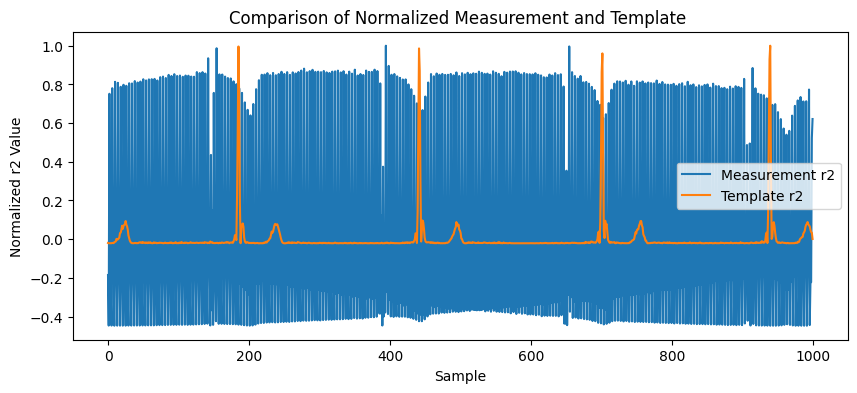

In [ ]:
# Normalize the template and measurement r2 values
# r2_template_normalized = (r2_template - np.mean(r2_template)) / np.std(r2_template) / np.max(r2_template)
# r2_measurement_normalized = (r2_measurement_noisy - np.mean(r2_measurement_noisy)) / np.std(r2_measurement_noisy) / np.max(r2_measurement_noisy)
r2_template_normalized = (r2_template - np.mean(r2_template))
r2_measurement_normalized = (r2_measurement_noisy - np.mean(r2_measurement_noisy))
r2_template_normalized = r2_template_normalized  / np.max(r2_template_normalized)
r2_measurement_normalized = r2_measurement_normalized   / np.max(r2_measurement_normalized)

plt.figure(figsize=(10, 4))
plt.plot(r2_measurement_normalized, label='Measurement r2')
plt.plot(r2_template_normalized, label='Template r2')
plt.title('Comparison of Normalized Measurement and Template ')
plt.xlabel('Sample')
plt.ylabel('Normalized r2 Value')
plt.legend()
plt.show()

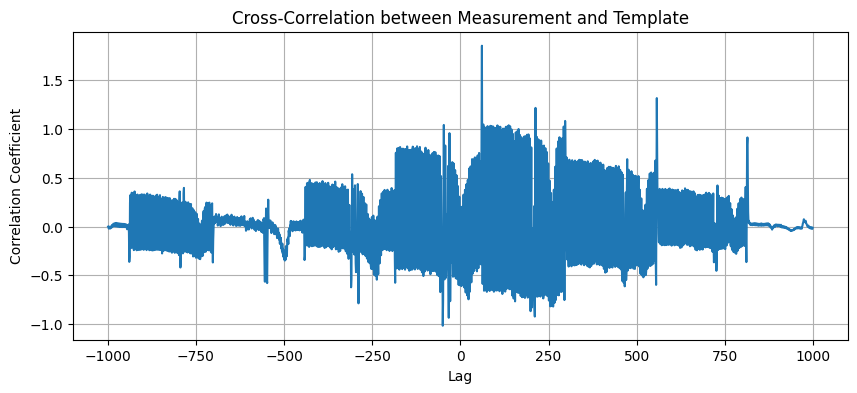

In [ ]:
# --- Step 3: Compute the Cross-Correlation ---

from scipy.signal import correlate

# Compute the cross-correlation
correlation = correlate(r2_measurement_normalized, r2_template_normalized, mode='full')

# Compute the lags
lags = np.arange(-len(r2_measurement_normalized) + 1, len(r2_template_normalized))

# Plot the cross-correlation
plt.figure(figsize=(10, 4))
plt.plot(lags, correlation)
plt.title('Cross-Correlation between Measurement and Template')
plt.xlabel('Lag')
plt.ylabel('Correlation Coefficient')
plt.grid(True)
plt.show()


Maximum correlation at lag 61 with value 1.8545771078072677


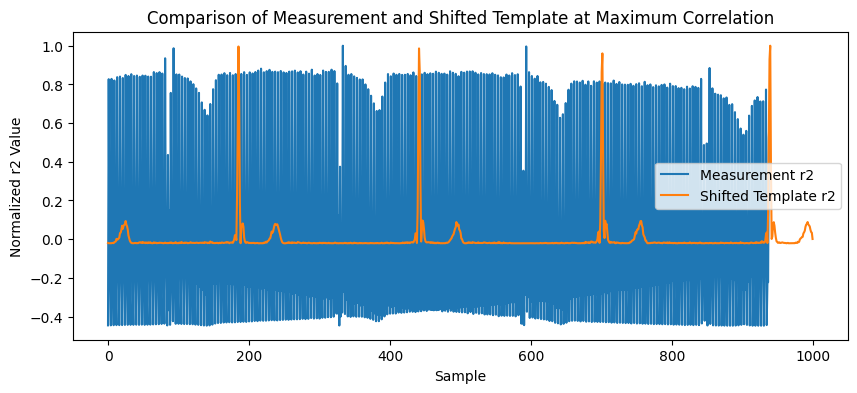

In [ ]:
# --- Step 4: Analyze the Correlation Output ---

# Find the lag with the maximum correlation
max_corr_index = np.argmax(correlation)
max_corr_value = correlation[max_corr_index]
max_corr_lag = lags[max_corr_index]

print(f"Maximum correlation at lag {max_corr_lag} with value {max_corr_value}")

# Plot the measurement r2 values and the template shifted by the lag
shifted_template_start = max_corr_lag
shifted_template_end = max_corr_lag + len(r2_template_normalized)

# Adjust indices for plotting
if shifted_template_start < 0:
    template_slice = r2_template_normalized[-shifted_template_start:]
    measurement_slice = r2_measurement_normalized[:shifted_template_end]
else:
    template_slice = r2_template_normalized
    measurement_slice = r2_measurement_normalized[shifted_template_start:shifted_template_end]

plt.figure(figsize=(10, 4))
plt.plot(measurement_slice, label='Measurement r2')
plt.plot(template_slice, label='Shifted Template r2')
plt.title('Comparison of Measurement and Shifted Template at Maximum Correlation')
plt.xlabel('Sample')
plt.ylabel('Normalized r2 Value')
plt.legend()
plt.show()


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import decimate, find_peaks

# Assumed constants and parameters (example values)
g_e = 2.00231930436256  # Electron g-factor
mu_B = 9.274009994e-24  # Bohr magneton (J/T)
h = 6.626e-34           # Planck constant (J·s)
base_frequency = 2.87e9 # Hz
gamma_true = 55e3       # Example gamma
gs_true = 0.019         # Example gs
k = 260e3
kc1 = 130e3
gammao = 2.23e3
Gamma = 330e3
Polarization = 0.1 # Just a placeholder, use correct values from your code
N = 1e18           # Placeholder, use from your code

def simulate_r2_numpy_vectorized(frequency, spin_freq, gamma, gs):
    # Replace this stub with your actual implementation
    # For demonstration, let's just return a synthetic peaky signal
    # In reality, use your real simulate_r2 function
    h_np = 6.626e-34
    energy_d = h_np * frequency
    Delta = spin_freq - frequency
    g = np.sqrt(N * Polarization) * gs * 0.16
    alpha2 = 10 ** (-18 / 10) * 1e-3 / (energy_d * kc1 * 2 * np.pi) * (0.53 ** 2)
    beta2 = alpha2 * kc1
    chi_0 = np.sqrt(1 + 8*(gamma/gammao)*(gs**2)*alpha2/(gamma**2))
    Gamma_1_0 = Gamma + chi_0*gamma
    geff_0 = g/chi_0
    denom = (Delta - (g**2)*Delta/((Gamma_1_0/2)**2+Delta**2))**2 + \
            (k/2 + (geff_0**2)*(Gamma_1_0/2)/((Gamma_1_0/2)**2+Delta**2))**2
    term1 = kc1 * beta2
    alpha2_1 = term1/denom
    r2 = (-1 + np.sqrt(kc1 * alpha2_1 / beta2 + 1e-12))**2
    return r2

256.0


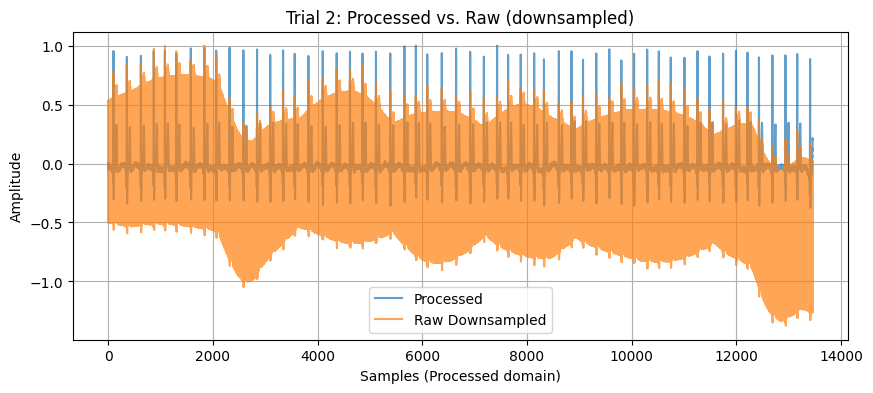

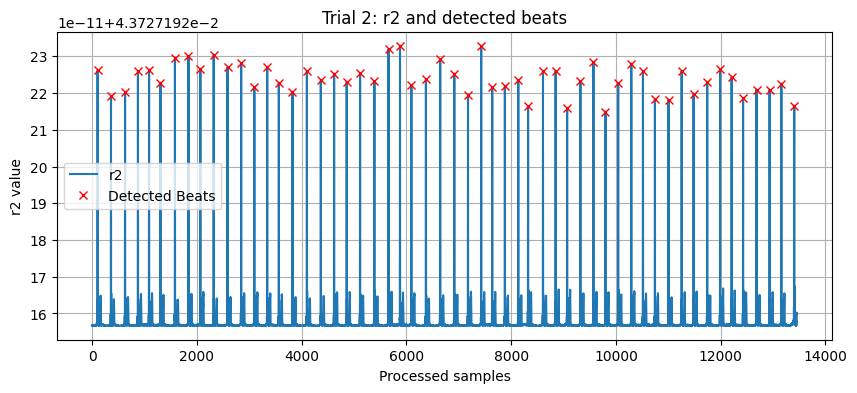

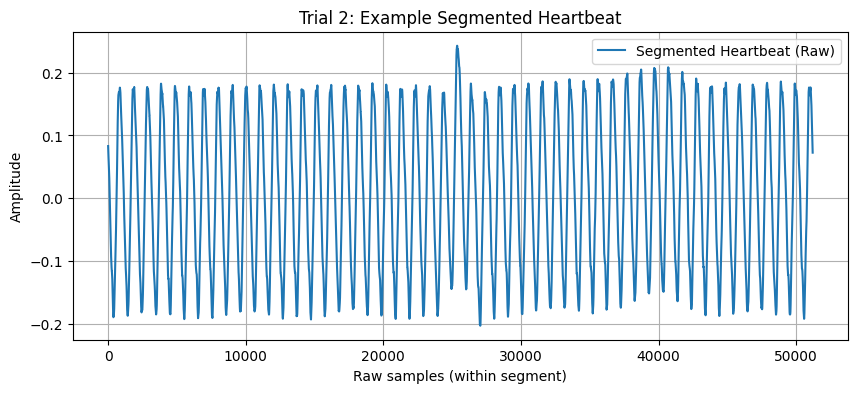

In [ ]:


data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data/subject1'
subject_id = 1
ch_idx = 1             # Using channel 1

# Parameters for heartbeat segmentation
window_size_processed = 200  # samples in processed domain
fs_processed = 200.0   # Usually known from the data
fs_raw = 51200.0       # If raw is 256x processed: 200*256=51200
decimation_factor = int(fs_raw / fs_processed) # 256

trial_num = 2
recording_name_raw = f'subject{subject_id}_raw_trial{trial_num:02d}'
recording_name_processed = f'subject{subject_id}_preprocessed_trial{trial_num:02d}'

# Read raw and processed data
record_raw = wfdb.rdrecord(f'{data_folder}/{recording_name_raw}')
record_processed = wfdb.rdrecord(f'{data_folder}/{recording_name_processed}')

signal_data_raw = record_raw.p_signal[int(200*256):-int(200*256),:]  # shape: [N_raw, channels]
signal_data_processed = record_processed.p_signal[200:-200,:] # shape: [N_processed, channels]

fs_raw = record_raw.fs
fs_processed = record_processed.fs

N_raw = signal_data_raw.shape[0]
N_processed = signal_data_processed.shape[0]

# Check the ratio
expected_ratio = 256
actual_ratio = N_raw / N_processed
print(actual_ratio)
if not np.isclose(actual_ratio, expected_ratio, atol=0.1):
    print(f"Warning: ratio not as expected for trial {trial_num}. Ratio={actual_ratio}")

# Plot to verify alignment
# Downsample raw to match processed length
raw_downsampled = decimate(signal_data_raw[:, ch_idx], decimation_factor, zero_phase=True)

proc_scaled = signal_data_processed[:, ch_idx] / np.max(signal_data_processed[:, ch_idx])
raw_scaled = raw_downsampled / np.max(raw_downsampled)

plt.figure(figsize=(10,4))
plt.plot(proc_scaled, label='Processed', alpha=0.7)
plt.plot(raw_scaled, label='Raw Downsampled', alpha=0.7)
plt.title(f"Trial {trial_num}: Processed vs. Raw (downsampled)")
plt.xlabel('Samples (Processed domain)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()
plt.show()

# Assume we can use processed data to compute r2:
# Convert processed data (pT to T if needed)
# For demonstration, let's assume processed data is already B-field in pT
# Convert pT to T:
B_field_pT = signal_data_processed[:, ch_idx]
B_field_T = B_field_pT * 1e-12

# Compute spin frequencies
C = (g_e * mu_B) / h
delta_f = C * B_field_T
spin_freq = base_frequency + delta_f

# Compute r2 from processed data
frequency = base_frequency
r2_values = simulate_r2_numpy_vectorized(frequency, spin_freq, gamma_true, gs_true)

# Identify heartbeats
# A simple approach: find peaks in r2 above a certain threshold
# threshold could be mean + some factor of std
threshold = np.mean(r2_values) + 2*np.std(r2_values)
peaks, _ = find_peaks(r2_values, height=threshold)

# The "center" of each heartbeat: we take the peak index as center
heartbeat_indices_processed = peaks

# Plot r2 and mark beats
plt.figure(figsize=(10,4))
plt.plot(r2_values, label='r2')
plt.plot(heartbeat_indices_processed, r2_values[heartbeat_indices_processed], 'rx', label='Detected Beats')
plt.title(f"Trial {trial_num}: r2 and detected beats")
plt.xlabel('Processed samples')
plt.ylabel('r2 value')
plt.grid(True)
plt.legend()
plt.show()

# Now segment the raw data around each detected beat
# Map processed indices to raw indices
# raw_index = processed_index * decimation_factor
heartbeat_indices_raw = heartbeat_indices_processed * decimation_factor

# Define a window size around each beat
# For example, if window_size_processed = 200, that means 100 samples before and after the beat in processed domain.
# In raw domain, window_size_raw = window_size_processed * decimation_factor
window_size_raw = window_size_processed * decimation_factor
half_window_raw = window_size_raw // 2

# Create segments for each heartbeat
raw_segments = []
for raw_idx in heartbeat_indices_raw:
    start = raw_idx - half_window_raw
    end = raw_idx + half_window_raw
    # Check boundaries
    if start < 0 or end > (N_raw - 1):
        continue
    segment = signal_data_raw[start:end, ch_idx]
    raw_segments.append(segment)

# Plot an example snippet of a segmented heartbeat
if raw_segments:
    plt.figure(figsize=(10,4))
    plt.plot(raw_segments[0], label='Segmented Heartbeat (Raw)')
    plt.title(f"Trial {trial_num}: Example Segmented Heartbeat")
    plt.xlabel('Raw samples (within segment)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.legend()
    plt.show()

# At this point, you have segmented the raw data into individual heartbeat windows
# Repeat this for all trials
# raw_segments now holds data for all detected heartbeats in that trial.

# You would store or process these segments as needed for your training.
# For demonstration, we just did one trial in detail. The loop runs over all trials.


In [ ]:
!pip install wfdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from scipy.signal import decimate, find_peaks
import matplotlib.pyplot as plt
import wfdb
import os

In [ ]:
data_folder = '/content/drive/My Drive/MIT/MEng/MCG_data/subject1'

subject_id = 1
num_trials = 25
channel_index = 1  # Using channel 1 (second channel)
raw_filename_template = 'subject1_raw_trial{:02d}'
processed_filename_template = 'subject1_preprocessed_trial{:02d}'
gamma_true = 55e3       # Example gamma
gs_true = 0.019         # Example gs
base_frequency = 2.87e9 # Hz

# We want 40 heartbeats per trial
desired_beats_per_trial = 40

# Define heartbeat window in processed samples (e.g., 1 second window)
window_size = 160
half_window = window_size // 2
window_size_raw = window_size * 256
half_window_raw = window_size_raw // 2
trim_samples = 200  # number of samples (processed) to trim from each end

# Initialize array to hold all heartbeats from all trials
# Shape: (num_trials, desired_beats_per_trial, window_size_raw)
all_heartbeats_raw = np.zeros((num_trials, desired_beats_per_trial, window_size_raw))
all_heartbeats_processed = np.zeros((num_trials, desired_beats_per_trial, window_size))

def compute_spin_freq(B_field_pT, base_frequency=2.87e9):
    h = 6.626e-34
    mu_B = 9.274009994e-24
    g_e = 2.00231930436256
    B_field_T = B_field_pT * 1e-12
    delta_f = g_e * mu_B * B_field_T / h
    spin_freq = base_frequency + delta_f
    return spin_freq

for trial_num in range(1, num_trials + 1):
    # Paths
    raw_path = os.path.join(data_folder, raw_filename_template.format(trial_num))
    processed_path = os.path.join(data_folder, processed_filename_template.format(trial_num))

    # Read records
    record_raw = wfdb.rdrecord(raw_path)
    record_processed = wfdb.rdrecord(processed_path)

    signal_data_raw = record_raw.p_signal
    signal_data_processed = record_processed.p_signal

    raw_len = signal_data_raw.shape[0]
    processed_len = signal_data_processed.shape[0]

    expected_raw_len = processed_len * 256
    if raw_len != expected_raw_len:
        print(f"Warning: trial {trial_num} raw length ({raw_len}) != 256 * processed length ({processed_len})")
        continue

    # Extract channel data
    raw_channel = signal_data_raw[:, channel_index]
    processed_channel = signal_data_processed[:, channel_index]

    # Trim the data to avoid weird behavior at ends
    # Trim "trim_samples" from start and end in processed space
    # In raw space, that's trim_samples*256
    start_processed = trim_samples
    end_processed = processed_len - trim_samples
    if end_processed <= start_processed:
        print(f"Not enough data after trimming for trial {trial_num}. Skipping.")
        continue

    # Trim processed data
    processed_channel_trimmed = processed_channel[start_processed:end_processed]

    # Corresponding raw indices
    start_raw = start_processed * 256
    end_raw = end_processed * 256
    raw_channel_trimmed = raw_channel[start_raw:end_raw]

    processed_len_trimmed = len(processed_channel_trimmed)
    raw_len_trimmed = len(raw_channel_trimmed)

    # Compute r2 from processed (trimmed)
    spin_freq_processed = compute_spin_freq(processed_channel_trimmed)
    frequency = base_frequency
    r2_values_processed = simulate_r2_numpy_vectorized(frequency, spin_freq_processed, gamma_true, gs_true)
    spin_freq_raw = compute_spin_freq(raw_channel_trimmed, base_frequency)
    r2_values_raw =  simulate_r2_numpy_vectorized(frequency, spin_freq_raw, gamma_true, gs_true)

    if trial_num==1:
      print(r2_values_processed)
      print(r2_values_raw)


    # Detect heartbeats using peaks in r2
    r2_threshold = np.mean(r2_values_processed) + 2 * np.std(r2_values_processed)
    peaks, _ = find_peaks(r2_values_processed, height=r2_threshold)

    # Convert these peak indices (in processed domain) back to global indices if needed
    # Actually, we only need them relative to the trimmed data now.
    # Each peak index is relative to the start_processed offset.
    # For raw data indexing:
    # global processed index = start_processed + peak
    # raw index = (start_processed + peak) * 256
    # We'll convert them directly here:
    peak_raw_indices = (start_processed + peaks) * 256
    peak_processed_indices = start_processed + peaks

    # Extract heartbeat segments from raw and processed data
    heartbeat_segments_raw = []
    for p_idx in peak_raw_indices:
        start_seg = p_idx - half_window_raw
        end_seg = p_idx + half_window_raw
        # Check if segment is within trimmed raw data bounds
        if start_seg < start_raw or end_seg > (start_raw + raw_len_trimmed):
            # If we can't get a full window (because it's near an edge), skip
            continue
        # Adjust indices to be relative to the start of the trimmed raw data
        relative_start = start_seg - start_raw
        relative_end = end_seg - start_raw
        segment = r2_values_raw[relative_start:relative_end]
        if len(segment) == window_size_raw:
            heartbeat_segments_raw.append(segment)

    heartbeat_segments_processed = []
    for p_idx in peak_processed_indices:
        start_seg = p_idx - half_window
        end_seg = p_idx + half_window
        # Check if segment is within trimmed processed data bounds
        if start_seg < start_processed or end_seg > (start_processed + processed_len_trimmed):
            # If we can't get a full window (because it's near an edge), skip
            continue
        # Adjust indices to be relative to the start of the trimmed raw data
        relative_start = start_seg - start_processed
        relative_end = end_seg - start_processed
        segment = r2_values_processed[relative_start:relative_end]
        if len(segment) == window_size:
            heartbeat_segments_processed.append(segment)

    heartbeat_segments_raw = np.array(heartbeat_segments_raw)
    heartbeat_segments_processed = np.array(heartbeat_segments_processed)

    # We now have an array of shape (num_beats_found, window_size_raw).
    # Ensure we have at least desired_beats_per_trial (40) if possible.
    # If more than 40, take the first 40.
    # If fewer than 40, pad with zeros.

    num_beats = len(heartbeat_segments_raw)
    if num_beats == 0:
        # No heartbeats found or couldn't extract segments
        print(f"No valid heartbeats found for trial {trial_num}. It will be all zeros.")
        # all_heartbeats for this trial remains zeros
    else:
        count = min(num_beats, desired_beats_per_trial)
        all_heartbeats_raw[trial_num - 1, :count, :] = heartbeat_segments_raw[:count]
        # If fewer than 40, the rest remain zeros.

    # Optionally, you can print a message
    print(f"Trial {trial_num}: Found {num_beats} beats, using {min(num_beats, desired_beats_per_trial)}.")

    num_beats = len(heartbeat_segments_processed)
    if num_beats == 0:
        # No heartbeats found or couldn't extract segments
        print(f"No valid heartbeats found for trial {trial_num}. It will be all zeros.")
        # all_heartbeats for this trial remains zeros
    else:
        count = min(num_beats, desired_beats_per_trial)
        all_heartbeats_processed[trial_num - 1, :count, :] = heartbeat_segments_processed[:count]
        # If fewer than 40, the rest remain zeros.

    # Optionally, you can print a message
    print(f"Trial {trial_num}: Found {num_beats} beats, using {min(num_beats, desired_beats_per_trial)}.")

# # After processing all trials, save the dataset
save_path = os.path.join(data_folder, 'subject1_heartbeat_dataset_raw.npy')
np.save(save_path, all_heartbeats_raw)
print(f"Saved dataset to {save_path}")

save_path = os.path.join(data_folder, 'subject1_heartbeat_dataset_processed.npy')
np.save(save_path, all_heartbeats_processed)
print(f"Saved dataset to {save_path}")

[0.04372719 0.04372719 0.04372719 ... 0.04372719 0.04372719 0.04372719]
[0.04372719 0.04372719 0.04372719 ... 0.04372719 0.04372719 0.04372719]
Trial 1: Found 56 beats, using 40.
Trial 1: Found 56 beats, using 40.
Trial 2: Found 54 beats, using 40.
Trial 2: Found 54 beats, using 40.
Trial 3: Found 54 beats, using 40.
Trial 3: Found 54 beats, using 40.
Trial 4: Found 61 beats, using 40.
Trial 4: Found 61 beats, using 40.
Trial 5: Found 104 beats, using 40.
Trial 5: Found 104 beats, using 40.
Trial 6: Found 52 beats, using 40.
Trial 6: Found 52 beats, using 40.
Trial 7: Found 51 beats, using 40.
Trial 7: Found 51 beats, using 40.
Trial 8: Found 53 beats, using 40.
Trial 8: Found 53 beats, using 40.
Trial 9: Found 51 beats, using 40.
Trial 9: Found 51 beats, using 40.
Trial 10: Found 51 beats, using 40.
Trial 10: Found 51 beats, using 40.
Trial 11: Found 49 beats, using 40.
Trial 11: Found 49 beats, using 40.
Trial 12: Found 49 beats, using 40.
Trial 12: Found 49 beats, using 40.
Trial 13

In [ ]:
# Define a separate array for non-heartbeat segments
all_non_heartbeats_raw = np.zeros((num_trials, desired_beats_per_trial, window_size_raw))
all_non_heartbeats_processed = np.zeros((num_trials, desired_beats_per_trial, window_size))

# The offset in processed samples to shift from the heartbeat
non_heartbeat_offset = 100

for trial_num in range(1, num_trials + 1):
    # Paths
    raw_path = os.path.join(data_folder, raw_filename_template.format(trial_num))
    processed_path = os.path.join(data_folder, processed_filename_template.format(trial_num))

    # Read records
    record_raw = wfdb.rdrecord(raw_path)
    record_processed = wfdb.rdrecord(processed_path)

    signal_data_raw = record_raw.p_signal
    signal_data_processed = record_processed.p_signal

    raw_len = signal_data_raw.shape[0]
    processed_len = signal_data_processed.shape[0]

    expected_raw_len = processed_len * 256
    if raw_len != expected_raw_len:
        print(f"Warning: trial {trial_num} raw length ({raw_len}) != 256 * processed length ({processed_len})")
        continue

    # Extract channel data
    raw_channel = signal_data_raw[:, channel_index]
    processed_channel = signal_data_processed[:, channel_index]

    # Trim data
    start_processed = trim_samples
    end_processed = processed_len - trim_samples
    if end_processed <= start_processed:
        print(f"Not enough data after trimming for trial {trial_num}. Skipping.")
        continue

    processed_channel_trimmed = processed_channel[start_processed:end_processed]
    start_raw = start_processed * 256
    end_raw = end_processed * 256
    raw_channel_trimmed = raw_channel[start_raw:end_raw]

    processed_len_trimmed = len(processed_channel_trimmed)
    raw_len_trimmed = len(raw_channel_trimmed)

    # Compute r2 and detect heartbeats as before
    spin_freq_processed = compute_spin_freq(processed_channel_trimmed)
    frequency = base_frequency
    r2_values_processed = simulate_r2_numpy_vectorized(frequency, spin_freq_processed, gamma_true, gs_true)

    spin_freq_raw = compute_spin_freq(raw_channel_trimmed, base_frequency)
    r2_values_raw = simulate_r2_numpy_vectorized(frequency, spin_freq_raw, gamma_true, gs_true)

    # if trial_num==1:
    #   print(r2_values_processed)
    #   print(r2_values_raw)

    r2_threshold = np.mean(r2_values_processed) + 2*np.std(r2_values_processed)
    peaks, _ = find_peaks(r2_values_processed, height=r2_threshold)

    peak_raw_indices = (start_processed + peaks) * 256
    peak_processed_indices = start_processed + peaks


    # Extract non-heartbeat segments
    # We'll try to extract segments shifted by "non_heartbeat_offset" processed samples from each peak.
    non_heartbeat_segments_raw = []
    non_heartbeat_segments_processed = []

    for p_idx in peak_processed_indices:
        # Shift by non_heartbeat_offset
        shifted_idx = p_idx - non_heartbeat_offset

        # Window around shifted_idx (no heartbeat zone)
        start_seg_proc = shifted_idx - half_window
        end_seg_proc = shifted_idx + half_window

        # Check processed domain bounds
        if start_seg_proc < start_processed or end_seg_proc > (start_processed + processed_len_trimmed):
            continue

        # Corresponding raw domain indices
        start_seg_raw = start_seg_proc * 256
        end_seg_raw = end_seg_proc * 256

        if start_seg_raw < start_raw or end_seg_raw > (start_raw + raw_len_trimmed):
            continue

        # Extract segments
        # Processed segment
        rel_start_proc = start_seg_proc - start_processed
        rel_end_proc = end_seg_proc - start_processed
        seg_proc = r2_values_processed[rel_start_proc:rel_end_proc]

        # Raw segment
        rel_start_raw = start_seg_raw - start_raw
        rel_end_raw = end_seg_raw - start_raw
        seg_raw = r2_values_raw[rel_start_raw:rel_end_raw]

        if len(seg_proc) == window_size and len(seg_raw) == window_size_raw:
            non_heartbeat_segments_processed.append(seg_proc)
            non_heartbeat_segments_raw.append(seg_raw)

    non_heartbeat_segments_raw = np.array(non_heartbeat_segments_raw)
    non_heartbeat_segments_processed = np.array(non_heartbeat_segments_processed)

    # Choose up to 40 non-heartbeat segments
    num_non_beats = len(non_heartbeat_segments_raw)
    if num_non_beats == 0:
        print(f"No non-heartbeat segments found for trial {trial_num}.")
    else:
        count = min(num_non_beats, desired_beats_per_trial)
        all_non_heartbeats_raw[trial_num - 1, :count, :] = non_heartbeat_segments_raw[:count]
        all_non_heartbeats_processed[trial_num - 1, :count, :] = non_heartbeat_segments_processed[:count]
        print(f"Trial {trial_num}: Found {num_non_beats} non-heartbeat segments, using {count}.")

print(all_non_heartbeats_raw)
print(all_non_heartbeats_processed)

# After processing all trials, save the non-heartbeat dataset
save_path = os.path.join(data_folder, 'subject1_non_heartbeat_dataset_raw.npy')
np.save(save_path, all_non_heartbeats_raw)
print(f"Saved non-heartbeat dataset to {save_path}")

save_path = os.path.join(data_folder, 'subject1_non_heartbeat_dataset_processed.npy')
np.save(save_path, all_non_heartbeats_processed)
print(f"Saved non-heartbeat dataset to {save_path}")


Trial 1: Found 56 non-heartbeat segments, using 40.
Trial 2: Found 54 non-heartbeat segments, using 40.
Trial 3: Found 53 non-heartbeat segments, using 40.
Trial 4: Found 63 non-heartbeat segments, using 40.
Trial 5: Found 104 non-heartbeat segments, using 40.
Trial 6: Found 52 non-heartbeat segments, using 40.
Trial 7: Found 50 non-heartbeat segments, using 40.
Trial 8: Found 53 non-heartbeat segments, using 40.
Trial 9: Found 51 non-heartbeat segments, using 40.
Trial 10: Found 51 non-heartbeat segments, using 40.
Trial 11: Found 49 non-heartbeat segments, using 40.
Trial 12: Found 48 non-heartbeat segments, using 40.
Trial 13: Found 50 non-heartbeat segments, using 40.
Trial 14: Found 48 non-heartbeat segments, using 40.
Trial 15: Found 55 non-heartbeat segments, using 40.
Trial 16: Found 52 non-heartbeat segments, using 40.
Trial 17: Found 55 non-heartbeat segments, using 40.
Trial 18: Found 53 non-heartbeat segments, using 40.
Trial 19: Found 54 non-heartbeat segments, using 40.
T